# SARIMA (Seasonal AutoRegressive Integrated Moving Average) Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()

In [3]:
# Read in Catfish sales data
catfish_sales = pd.read_csv('./data/catfish.csv', index_col=0, parse_dates=[0], date_format="%Y-%m-%d")
catfish_sales = catfish_sales.squeeze()

In [5]:
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [6]:
start_date = datetime(1996, 1, 1)
end_date = datetime(2000, 1, 1)
lim_catfish_sales = catfish_sales[start_date: end_date]

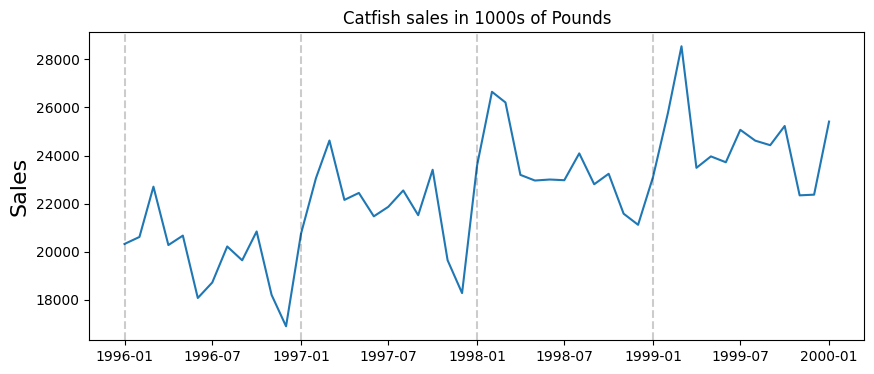

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(lim_catfish_sales)
plt.title("Catfish sales in 1000s of Pounds")
plt.ylabel("Sales", fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle="--", alpha=0.2)

## Remove Trend

In [8]:
first_diff = lim_catfish_sales.diff()[1:]

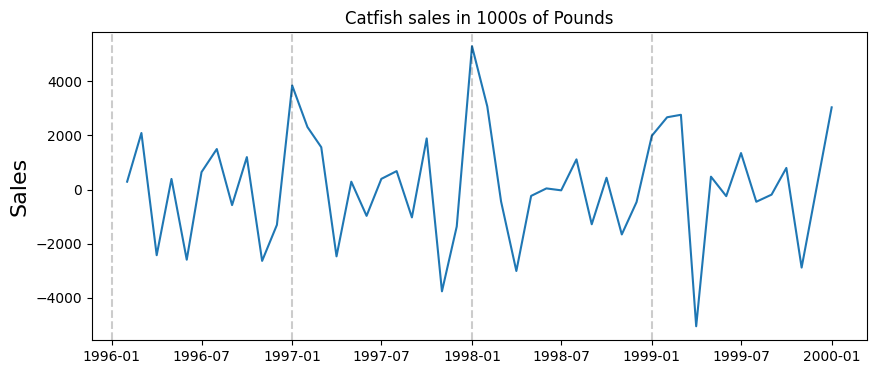

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(first_diff)
plt.title("Catfish sales in 1000s of Pounds")
plt.ylabel("Sales", fontsize=16)
for year in range(start_date.year, end_date.year):
    plt.axvline(pd.to_datetime(f"{year}-01-01"), color='k', linestyle="--", alpha=0.2)

## ACF and PACF

Text(0.5, 1.0, 'ACF')

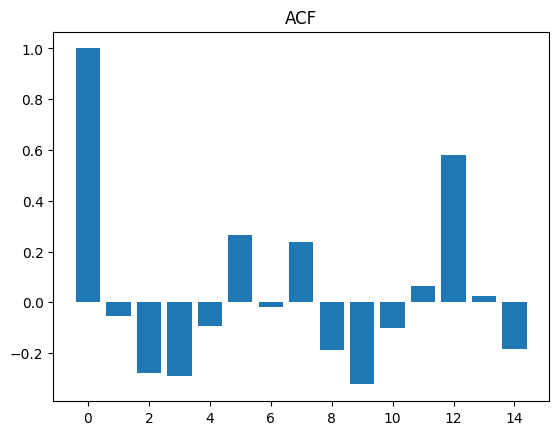

In [12]:
num_lags = 15
acf_vals = acf(first_diff)
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.title("ACF")

Text(0.5, 1.0, 'PACF')

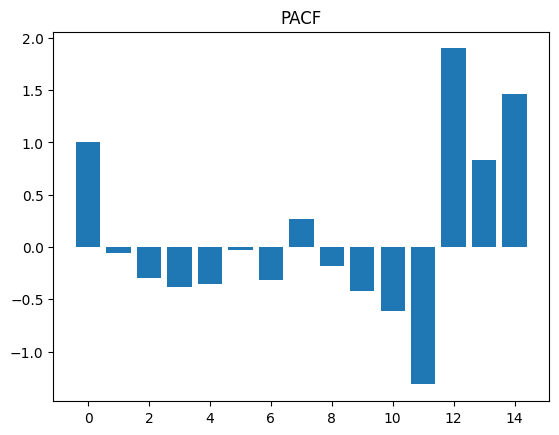

In [13]:
pacf_vals = pacf(first_diff)
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.title("PACF")

### ACF

We don't see significant lags in the ACF until around 12 (1 year), indicating we should use a seasonal MA process -> MA(1) for seasonal component


### PACF

PACF have a similar behavior where there's no significant lags until around 12 (1 year), indicating we should start with a seasonal AR process -> AR(1) for seasonal component

## Get train and test data

In [14]:
train_end = datetime(1999, 7, 1)
test_end = datetime(2000, 1, 1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1): test_end]

## Fit SARIMA model

In [15]:
my_order = (0, 1, 0) # 1 since we took the first difference to get rid of the upwards trend
my_seasonal_order = (1, 0, 1, 12) # AR(1), MA(1) for seasonal component. m = 12: 12 data points for pattern to repeat
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [16]:
start = time.time()
sarima_model = model.fit()
end = time.time()
print(f"Model fitting time: {end - start}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89920D+00    |proj g|=  1.35680D+00

At iterate    5    f=  8.55864D+00    |proj g|=  2.82664D-01

At iterate   10    f=  8.53795D+00    |proj g|=  1.36698D-03

At iterate   15    f=  8.53795D+00    |proj g|=  1.19740D-03

At iterate   20    f=  8.53785D+00    |proj g|=  1.51118D-02

At iterate   25    f=  8.52306D+00    |proj g|=  1.07976D-02

At iterate   30    f=  8.51675D+00    |proj g|=  1.44752D-02

At iterate   35    f=  8.50351D+00    |proj g|=  7.69844D-03

At iterate   40    f=  8.50313D+00    |proj g|=  2.52824D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/dan/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/dan/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


In [17]:
print(sarima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Sun, 15 Sep 2024   AIC                            737.269
Time:                                      14:01:33   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.121      6.845      0.000       0.589       1.061
ma.S.L12      -0.51

In [18]:
predictions = sarima_model.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)

residuals = test_data - predictions

Text(0, 0.5, 'Error')

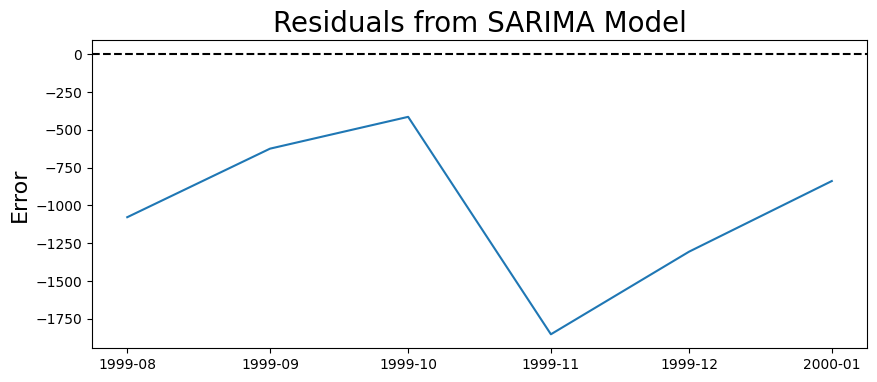

In [19]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

The fact that the residuals are consistently below 0 shows a systematic bias

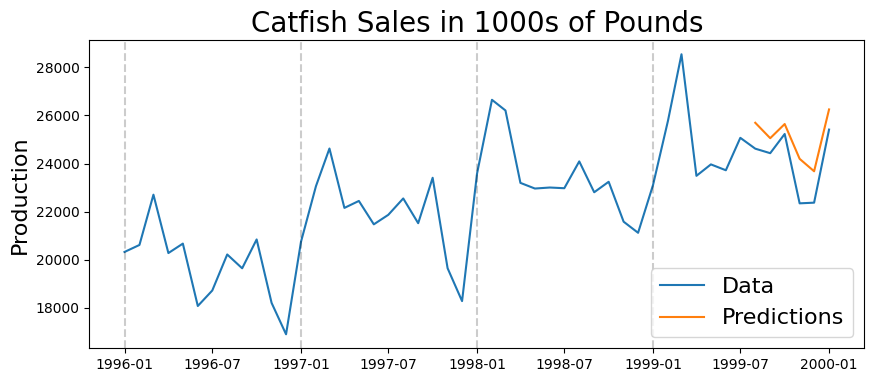

In [20]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

We see that we are constantly overshooting our prediction, as suggested by our residual's systematic bias

In [21]:
print(f"Mean Absolute Percent Error: {round(np.mean(abs(residuals/test_data)), 4)}")

Mean Absolute Percent Error: 0.0433


In [22]:
print(f"Root Mean Squared Error: {np.sqrt(np.mean(residuals**2))}")

Root Mean Squared Error: 1122.2814257651041


# Using Rolling Forecast


Idea of rolling forecast:

Instead of predicting all 6 months ahead in one go, we predict one month ahead at a time, using the previous error to inform out next month's prediction.

In [24]:
rolling_predictions = test_data.copy()

for train_end in test_data.index:
    train_data = lim_catfish_sales[: train_end - timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

    sarima_model = model.fit()
    predictions = sarima_model.forecast()
    rolling_predictions[train_end] = predictions


/home/dan/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/dan/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/tmp/ipykernel_760508/3445105700.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25695.43056932]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = predictions
/home/dan/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89920D+00    |proj g|=  1.35680D+00

At iterate    5    f=  8.55864D+00    |proj g|=  2.82664D-01

At iterate   10    f=  8.53795D+00    |proj g|=  1.36698D-03

At iterate   15    f=  8.53795D+00    |proj g|=  1.19740D-03

At iterate   20    f=  8.53785D+00    |proj g|=  1.51118D-02

At iterate   25    f=  8.52306D+00    |proj g|=  1.07976D-02

At iterate   30    f=  8.51675D+00    |proj g|=  1.44752D-02

At iterate   35    f=  8.50351D+00    |proj g|=  7.69844D-03

At iterate   40    f=  8.50313D+00    |proj g|=  2.52824D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/tmp/ipykernel_760508/3445105700.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = predictions
/home/dan/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.
/tmp/ipykernel_760508/3445105700.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = predictions
/home/dan/miniconda3/envs/ml/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'

In [25]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

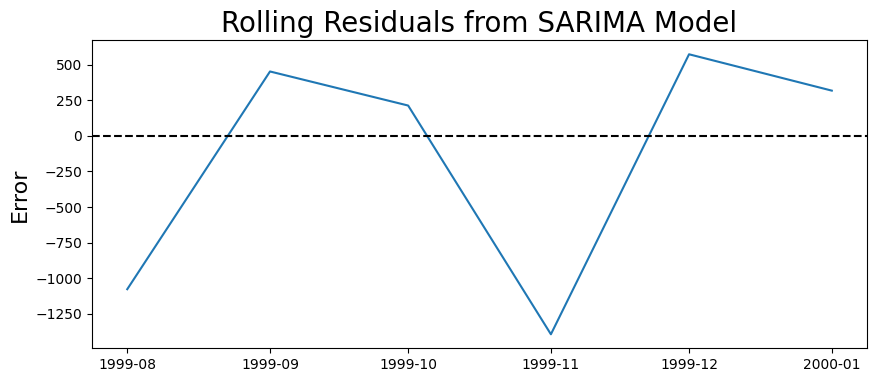

In [26]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Looks like there's less systematic bias in the residuals, and the error seems to be more centered towards 0.

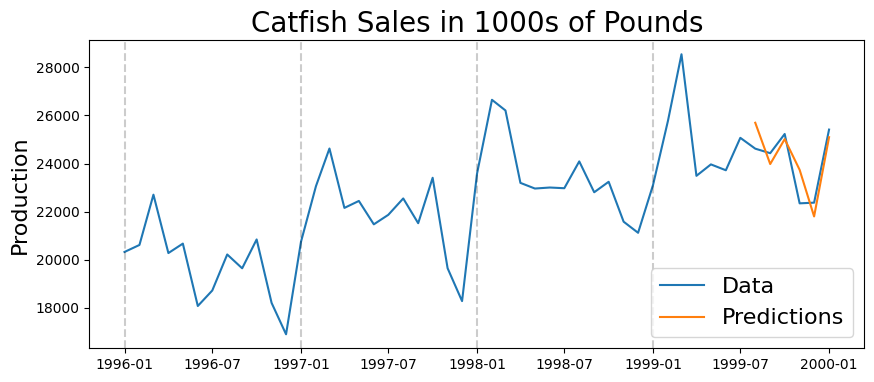

In [27]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [31]:
print(f"Mean Absolute Percent Error: {round(np.mean(abs(rolling_residuals/test_data)), 4)}")

Mean Absolute Percent Error: 0.0285


In [30]:
print(f"Root Mean Squared Error: {np.sqrt(np.mean(rolling_residuals**2))}")

Root Mean Squared Error: 793.9048710993387


Error significantly decreased with a rolling forecast